<a href="https://colab.research.google.com/github/adilabduakhanov/Colab-Projects/blob/main/HR_consultant(conducting%20interviews).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нейро-HR: проведение собеседований
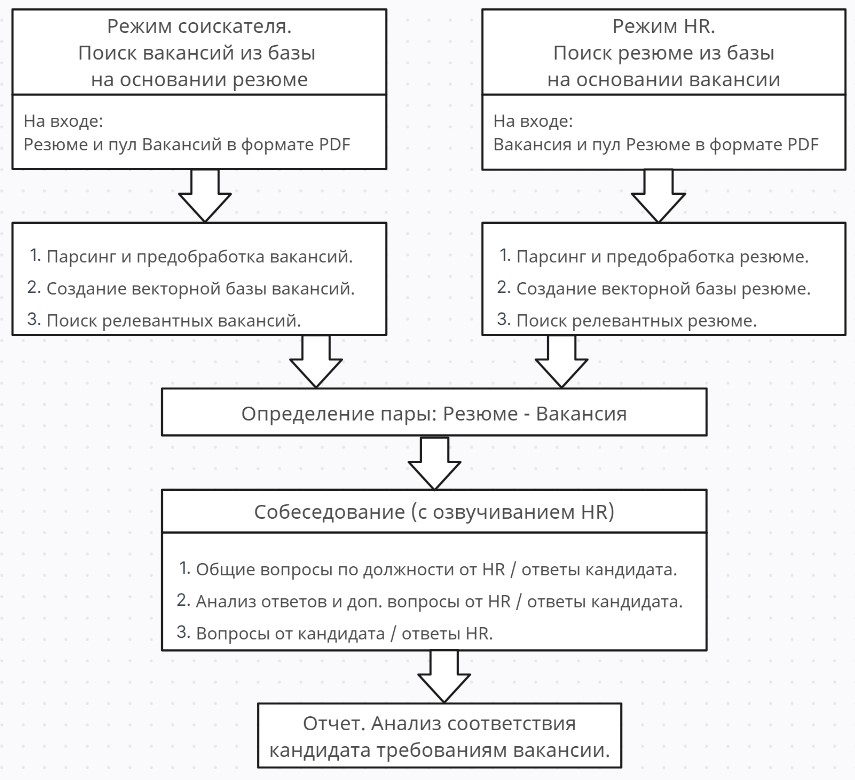

# Библиотеки. Функции. Предобработка данных

In [ ]:
#@title Установка необходимых библиотек
!pip install -q openai langchain langchain_community \
langchain_openai langchain_core faiss-cpu \
rarfile PyPDF2


In [ ]:
#@title Импорт библиотек, активация ключей, папки, глобальные переменные

from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.vectorstores import FAISS
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate


from io import BytesIO
import aiohttp
from google.colab import userdata, drive
from PyPDF2 import PdfReader
from datetime import datetime
import requests
from urllib.parse import urlencode
import textwrap
import rarfile
import openai
import gdown
import json
import time
import os
import re

# Подключаем ГуглДиск для работы с файлами
drive.mount('/content/drive')
# Формируем основной путь
path = '/content/drive/MyDrive/data/hr/'
# Формирование дополнительных путей
path_vacancies_pdf = f'{path}vacancies_pdf/'
path_vacancies_json = f'{path}vacancies_json/'
path_resumes_pdf = f'{path}resumes_pdf/'
path_resumes_json = f'{path}resumeses_json/'
path_db_faiss = f'{path}db_faiss/'
path_add_data = f'{path}add_data/'

folders = [path, path_vacancies_pdf, path_vacancies_json, path_resumes_pdf,
           path_resumes_json, path_db_faiss, path_add_data ]
# Создание необходимых папок на ГуглДиске: '/data/hr/...'
for folder in folders:
    os.makedirs(folder, exist_ok=True)

# Установка API-ключа OpenAI в качестве переменной среды
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

# Cоздание или очистка файла логов, если файл уже есть
open(os.path.join(path, '_log.txt'), 'w').close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Функии

# Функция для форматирования текста по абзацам
def format_text(text, width=120):
    # Разделяем текст на абзацы
    paragraphs = str(text).split('\n')
    # Форматируем каждый абзац отдельно
    formatted_paragraphs = []
    for paragraph in paragraphs:
        # Используем textwrap.fill для форматирования абзаца, чтобы длина строки не превышала width
        formatted_paragraph = textwrap.fill(paragraph, width)
        formatted_paragraphs.append(formatted_paragraph)
    # Объединяем абзацы с символом новой строки
    return '\n'.join(formatted_paragraphs)


# Функция записи логов в файл _log.txt
def add_log_file(text, title=''):
    time_now = f"{datetime.now().strftime('%Y-%m-%d %H:%M')}"
    with open(os.path.join(path, '_log.txt'), "a", encoding='utf-8') as file:
            file.write(f'\n\n{time_now}. {title}.\n\n{format_text(text)}')


# Функция подсчета количества используемых токенов и стоимость
# https://openai.com/pricing
def print_tokens_count_and_price(completion, model):
    if model == "gpt-4o":
        # gpt-4o - Input: $5 / 1M tokens - Output: $15 / 1M tokens
        input_price, output_price = 5, 15
    if model == "gpt-4o-mini":
        # gpt-4o-mini - Input: $0.15 / 1M tokens - Output: $0.60 / 1M tokens
        input_price, output_price = 0.15, 0.60
    price = input_price * completion.usage.prompt_tokens / 1e6 + \
            output_price * completion.usage.completion_tokens / 1e6
    print(f'Tokens used: {completion.usage.prompt_tokens} + '
                       f'{completion.usage.completion_tokens} = '
                       f'{completion.usage.total_tokens}. '
                       f'*** {model} *** $ {round(price, 5)}')


# Функция генерации ответа от OpenAI
def generate_answer(prompt_system, prompt_user, prompt_assistant='', model='gpt-4o-mini', temp=0.1):
    messages = [
        {"role": "system", "content": prompt_system},
        {'role': 'assistant', 'content': prompt_assistant},
        {"role": "user", "content": prompt_user}
    ]
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp,
        # max_tokens=4000
    )
    # Вывод количества используемых токенов и стоимость
    print_tokens_count_and_price(response, model=model)
    # Запись в лог-файл
    add_log_file(f'\n{messages}\n{response.choices[0].message.content}\n\n\n', title='generate_answer()')
    return response.choices[0].message.content


# Чтение PDF файла
def read_pdf(pdf_file):
    reader = PdfReader(pdf_file)
    # возвращаем текст построчно
    return ' '.join([line.extract_text() for line in reader.pages])


# Формируем поля для парсига Вакансии для последующего использовании при поиске
# https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/types/json/
"""Класс Vacancy с использованием библиотеки Pydantic, который будет использоваться для парсинга
   вакансий. Класс имеет четыре поля: position, skills, requirements и responsibilities. Описание
   для каждого поля включает инструкцию по извлечению соответствующих данных из текста вакансии."""

add_prompt = "Иначе, выведи ответ: None"
class Vacancy(BaseModel):
    position: str = Field(
        description = f'Найди в тексте вакансии название должности (позиции). {add_prompt}')
    skills: str = Field(
        description = re.sub(r'\s+', ' ', f"""Найди в тексте вакансии все указанные навыки.
                      {add_prompt}"""))
    requirements: str = Field(
        description = re.sub(r'\s+', ' ', f"""Найди в тексте вакансии все указанные требования.
                      {add_prompt}"""))
    responsibilities: str = Field(
        description = re.sub(r'\s+', ' ', f"""Найди в тексте вакансии все указанные обязанности.
                      {add_prompt}"""))


# Формируем поля для парсига Резюме для последующего использовании при поиске
# https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/types/json/
"""Класс Resume с использованием библиотеки Pydantic, который будет использоваться для парсинга
   резюме. Класс имеет три поля: position, skills и experience. Описание для каждого поля включает
   инструкцию по извлечению соответствующих данных из текста вакансии."""

add_prompt = "Иначе, выведи ответ: None"
class Resume(BaseModel):
    position: str = Field(
        description = f'Найди в тексте резюме название должности (позиции). {add_prompt}')
    skills: str = Field(
        description = re.sub(r'\s+', ' ', f"""Найди в тексте резюме все указанные навыки (стек).
                      {add_prompt}"""))
    experience: str = Field(
        description = re.sub(r'\s+', ' ', f"""Найди в тексте резюме описание прошлого опыта с
                      описанием деятельности. {add_prompt}"""))


# Парсинг текста с формированием полей по параметрам (parser_class=Vacancy или Resume)
# JSON parser https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/types/json/
def to_dict_parser(text, parser_class, model='gpt-4o') -> dict:
    # text: текст для парсинга
    # parser_class: класс парсера (например, Vacancy или Resume)
    # model: имя модели для генерации текста (по умолчанию 'gpt-4o')

    # Экземпляр JsonOutputParser (из langchain)
    parser = JsonOutputParser(pydantic_object=parser_class)
    prompt = PromptTemplate(
        input_variables = ["query"],
        # шаблон с инструкциями
        template = "Follow the instructions:\n"
                   "{format_instructions}\n"
                   "{query}\n",
        # встроенные инструкции JsonOutputParser по форматированию
        partial_variables = {"format_instructions": parser.get_format_instructions()})

    # цепочка (chain) из шаблона, модели и парсера
    # оператор '|' означает последовательное выполнение: шаблон -> модель -> парсер
    model = ChatOpenAI(model=model, temperature=0)
    chain = prompt | model | parser
    return chain.invoke({"query": text})


# Парсинг PDF файлов Вакансий и подготовка чанков для векторизации
# Cохранение данных вакансий в Json для удобства последующего использования
def pdf_to_json_and_chunks_vacancies(path_vacancies_pdf, model='gpt-4o-mini'):
    chunks_vacancies = [] # список для хранения чанков
    for file in os.listdir(path_vacancies_pdf): # Перебираем все файлы в указанной директории
        if file.endswith('.pdf'): # является ли файл PDF
            # From PDF to text
            vacancy = read_pdf(os.path.join(path_vacancies_pdf, file))
            add_log_file(vacancy, title='vacancy')
            # Парсинг текста вакансии и преобразование его в словарь с использованием заданного парсера и модели
            dict_vacancy = to_dict_parser(vacancy, parser_class=Vacancy, model=model)
            add_log_file(dict_vacancy, title='vacancy_to_dict_parser')

            vacancy_id = file.split('.')[0] # Имя файла без расширения .pdf
            # записываем в словарь дополнительные поля
            dict_vacancy['id'] = vacancy_id
            dict_vacancy['vacancy'] = vacancy # в т.ч. Вакансию целиком в словарь

            # Сохрание всех данных словаря в Json файл
            with open(os.path.join(path_vacancies_json, f'{vacancy_id}.json'), 'w', encoding='utf-8') as f:
                json.dump(dict_vacancy, f, ensure_ascii=False)

            # Формирование чанка для векторной базы вакансий
            chunk = re.sub(r'\s+', ' ',
                        f"""1.Позиция: {dict_vacancy.get('position', '')}.
                            2.Навыки: {dict_vacancy.get('skills', '')}.
                            3.Требования: {dict_vacancy.get('requirements', '')}.
                            4.Обязанности: {dict_vacancy.get('responsibilities', '')}.""")
            # Добавляем чанк каждой вакансии в список в формате Langchain Document
            chunks_vacancies.append(Document(page_content=chunk,
                                    metadata={"meta": f"{vacancy_id}"}))
    add_log_file(chunks_vacancies, title='pdf_to_json_and_chunks_vacancies')
    return chunks_vacancies # список чанков вакансий


# Парсинг PDF файлов Резюме и подготовка чанков для векторизации
# Cохранение данных резюме в Json для удобства последующего использования
def pdf_to_json_and_chunks_resumes(path_resumes_pdf, model='gpt-4o'):
    chunks_resumes = [] # список для хранения чанков
    for file in os.listdir(path_resumes_pdf): # Перебираем все файлы в указанной директории
        if file.endswith('.pdf'): # является ли файл PDF
            # From PDF to text
            resume = read_pdf(os.path.join(path_resumes_pdf, file))
            add_log_file(resume, title='read_pdf_resume')
            # Парсинг текста резюме и преобразование его в словарь с использованием заданного парсера и модели
            dict_resume = to_dict_parser(resume, parser_class=Resume, model=model)
            add_log_file(dict_resume, title='resume_to_dict_parser')

            resume_id = file.split('.')[0] # Имя файла резюме без расширения .pdf
            # записываем в словарь дополнительные поля
            dict_resume['id'] = resume_id
            dict_resume['resume'] = resume # в т.ч. Резюме целиком в словарь

            # Сохрание всех данных словаря в Json файл
            with open(os.path.join(path_resumes_json, f'{resume_id}.json'), 'w', encoding='utf-8') as f:
                json.dump(dict_resume, f, ensure_ascii=False)

            # Формирование чанка для векторной базы резюме
            chunk = re.sub(r'\s+', ' ',
                        f"""1.Позиция: {dict_resume.get('position', '')}.
                            2.Навыки: {dict_resume.get('skills', '')}.
                            3.Опыт: {dict_resume.get('experience', '')}.""")
            # Добавляем чанк каждого резюме в список в формате Langchain Document
            chunks_resumes.append(Document(page_content=chunk,
                                  metadata={"meta": f"{resume_id}"}))
    add_log_file(chunks_resumes, title='pdf_to_json_and_chunks_resumes')
    return chunks_resumes # список чанков


# Поиск релевантных чанков по запросу
def scores_and_meta_similarity(query, db_index, k=3):
    # query: текст для поиска релевантой информации
    # db_index: векторная база данных
    # k: количество возвращаемых результатов (по умолчанию 3)

    # Нахождение наиболее похожих документов на основе заданного запроса
    docs_and_scores = db_index.similarity_search_with_score(query, k=k)
    add_log_file(docs_and_scores, title='scores_and_meta_similarity')
    return ([doc[1] for doc in docs_and_scores],                   # List оценок (score) по результатам поиска
            [doc[0].metadata['meta'] for doc in docs_and_scores])  # Мeta list с именами файлов


# Загрузка фала из GoogleDisk по открытой ссылке
def download_from_google_disk(link, output_path):
    # link: открытая ссылка на файл в Google Диске
    # output_path: путь, куда будет сохранен загруженный файл
    # Идентификатор файла - это последовательность из 25 или более символов (букв, цифр, подчеркиваний, дефисов)
    id = re.findall(r'/d/([a-zA-Z0-9_-]{25,})', link)  # Находим идентификатор файла в ссылке
    direct_link = f'https://drive.google.com/uc?export=download&id={id[0]}'  # Формируем прямую ссылку
    add_log_file(direct_link, title='google_link') # Запись в лог-файл
    gdown.download(direct_link, output_path, quiet=True) # загрузка


# Загрузка фала из YandexDisk
def download_from_yandex_disk(link, output_path):
    # link: ссылка на файл в Yandex Диске
    # output_path: путь, куда будет сохранен загруженный файл
    # Базовый URL для получения информации о ресурсе
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources?'
    # Формируем финальный URL для запроса информации о ресурсе
    final_url = base_url + urlencode(dict(public_key=link))
    # Делаем запрос для получения информации о ресурсе
    response = requests.get(final_url)
    resource_info = response.json()
    # Получаем ссылку на скачивание файла
    download_url = resource_info['file']
    # Получаем имя файла
    file_name = resource_info['name']
    # Скачиваем файл
    download_response = requests.get(download_url)
    with open(os.path.join(output_path, file_name), 'wb') as f:
        f.write(download_response.content)
    add_log_file(link, title='yandex_link') # Запись в лог-файл


# Разархивирование содержимого архива в ту же папку
def unrar(path):
    for rar in os.listdir(path): # пробегаем по всем файлам в папке
        if rar.endswith('.rar'): # является ли файл арховом RAR
            filepath = os.path.join(path, rar) # путь к RAR файлу
            with rarfile.RarFile(filepath) as opened_rar:
                opened_rar.extractall(path) # разархивирование в ту же папку


# Функция дублирования строки с символом '#...'
def duplicate_lines(text):
    lines = text.split('\n')
    result = []
    for line in lines:
        if line.startswith('#'): # строка с символом '#...'
            result.append(line)
        result.append(line.lstrip('# ')) # дублируем без '#'
    return '\n'.join(result)


# Создание векторной базы из текстового файла с Markdown разметкой
def db_from_markdown_file(markdown_file):
    # Открываем и читаем содержимое Markdown файла
    with open(markdown_file, 'r', encoding='utf-8') as f:
        markdown_info = f.read()
    markdown_info = duplicate_lines(markdown_info)
    # Определяем заголовки, по которым будет выполняться разбиение текста
    # В данном случае, это заголовки уровня 1 (#)
    headers_to_split_on = [("#", "Header 1"),]
    # Экземпляр MarkdownHeaderTextSplitter с указанными заголовками для разбиения текста
    splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    # Разбиваем содержимое Markdown файла на чанки на основе заголовков
    chunks = splitter.split_text(markdown_info)
    # Создаем и возвращаем векторную базу данных FAISS
    return FAISS.from_documents(chunks, OpenAIEmbeddings())


# Функция диалога, поочередной подачи вопросов из списка и получение ответов
def ask_questions(questions):
    responses = []
    for question in questions:

        print(format_text(f"Рекрутер: {question}"), '\n')
        answer = input("Кандидат: ")
        formatted_answer = format_text(f"Кандидат: {answer}")
        # добаляем историю диалога в список
        responses.append(f"{question}\n\n{formatted_answer}\n\n")
        print('\n')
    add_log_file(responses, title='ask_questions(questions)')
    return responses


# Функция типовых вопросов
def conduct_interview(resume):
    text_start = f'Рекрутер: Здравствуйте! Давайте начнем собеседование. План собеседования следующий: \n 1. Я задам Вам несколько вопросов. \n 2. Расскажу о нашей компании и имеющейся вакансии \n 3. Отвечу на Ваши вопросы. \n Общайтесь пожалуйста со мной как с обычным рекрутером!'
    print(text_start, '\n')
    interview_summary = [f"Резюме:\n{resume}\n", "Интервью:\n"]
    # добаляем историю диалога в список
    interview_summary.extend(ask_questions(questions))
    add_log_file("\n".join(interview_summary), title='conduct_interview')
    # возвращаем резюме и историю диалога в текстовом виде (str)
    return "\n".join(interview_summary)


# Функция анализа диалога и генерация доп. вопросов
def generate_dialogue(prompt_system, prompt_user, model='gpt-4o'):
    print(f'Рекрутер: Подождите минутку. Я проанализирую Ваши ответы и сформулирую дополнительные вопросы.', '\n')
    answer = generate_answer(prompt_system, prompt_user, model=model)
    print(format_text(answer))
    return answer


# Функция дополнительных вопросов
def ask_additional_questions(questions):
    question_list = questions.split('\n') # формируем список из строк
    question_list = [q for q in question_list if q.strip()] # убираем из списка пустые строки
    additional_responses = ask_questions(question_list) # функция диалога
    add_log_file(additional_responses, title='ask_additional_questions') # Запись в лог-файл
    return additional_responses


# Функция презентации компании
def present_company_and_vacancy(company_description):
    text_presentation = f'Рекрутер: Спасибо, что ответили на все дополнительные вопросы. Теперь я хочу подробнее рассказать Вам о нашей организации. Нажмите Enter, когда будете готовы.'
    print(format_text(text_presentation), '\n')
    input()
    print(format_text(company_description), '\n\n')


# Функция ответа на вопросы кандидата
def handle_candidate_questions(candidate_position,
                               prompt_candidate_questions,
                               query_candidate_questions_template,
                               db_company_info,
                               model='gpt-4o-mini'):
    text_candidate_questions = f'Рекрутер: Если у Вас остались какие-либо вопросы, задайте их, пожалуйста, и я постараюсь ответить. Если вопросов нет, просто напишите "вопросов нет", и мы завершим наше собеседование.'
    print(format_text(text_candidate_questions), '\n\n')

    while True:
        candidate_question = input("Кандидат: ")
        print()
        if candidate_question.strip().lower() == 'вопросов нет':
            print("Рекрутер: Спасибо за собеседование! Желаем Вам удачи!")
            break
        candidate_question = f'Вопрос к позиции: {candidate_position}: {candidate_question}'
        # Полный вопрос кандидата с промптом
        query_candidate_questions = query_candidate_questions_template.format(candidate_question=candidate_question)
        # нахождение наиболее похожих документов на основе заданного вопроса кандидата
        docs = db_company_info.similarity_search(candidate_question, k=3) # search similarity

        # из списока объектов базы знаний docs, извлекаем атрибуты page_content (содержание документов) из каждого docs,
        # добавляем заголовок с форматом '\nChank {i+1}:\n' и объединяем их в строку с одним пробелом между каждым элементом.
        message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nChank {i+1}:\n' + \
                                                      doc.page_content + '\n' for i, doc in enumerate(docs)]))

        query_candidate_questions = f'# База знаний для ответов: \n{message_content} \n# {query_candidate_questions}'
        # Функция генерации ответа на вопрос
        answer = generate_answer(prompt_candidate_questions, query_candidate_questions, model=model, temp=0.3)
        add_log_file(f'{query_candidate_questions}\n{answer}', title='handle_candidate_questions')
        print("Рекрутер: " + format_text(answer))
        print()


# Функция генерации оценки кандидата
def generate_estimation(prompt_system, prompt_user, model='gpt-4o-mini'):
    print("Итоговый отчет по кандидату:", '\n')
    answer = generate_answer(prompt_system, prompt_user, model=model)
    print(format_text(answer))
    return answer

In [ ]:
#@title Загрузка PDF файлов вакансий и резюме

# Загрузка PDF файлов вакансий в RAR архиве
rar_vacancies = 'https://disk.yandex.ru/d/ece3qxT53I5CMw'
download_from_yandex_disk(rar_vacancies, path_vacancies_pdf)
unrar(path_vacancies_pdf) # разархивирование PDF вакансий в ту же папку

# Загрузка PDF файлов резюме в RAR архиве
rar_resumes = 'https://disk.yandex.ru/d/vxGW7qNelVT0YA'
download_from_yandex_disk(rar_resumes, path_resumes_pdf)
unrar(path_resumes_pdf) # разархивирование PDF резюме в ту же папку

In [ ]:
#@title Парсинг PDF, создания векторных баз

# Cоздание или очистка файла логов
open(os.path.join(path, '_log.txt'), 'w').close()

# Парсинг PDF файлов вакансий и резюме. Формирование чанков. Сохранение в Json
chunks_vacancies = pdf_to_json_and_chunks_vacancies(path_vacancies_pdf)
chunks_resumes = pdf_to_json_and_chunks_resumes(path_resumes_pdf)

# Создание и сохранение векторной базы вакансий для последующего релевантного поиска
db_vacancies = FAISS.from_documents(chunks_vacancies, OpenAIEmbeddings())
db_vacancies.save_local(folder_path=path_db_faiss, index_name='db_vacancies')

# Создание и сохранение векторной базы резюме для последующего релевантного поиска
db_resumes = FAISS.from_documents(chunks_resumes, OpenAIEmbeddings())
db_resumes.save_local(folder_path=path_db_faiss, index_name='db_resumes')

In [ ]:
#@title Создаем векторную базу ответов от HR

# Загружаем текстовый файл c информацией от HR с разметкой Markdown
hr_answers_link = 'https://disk.yandex.ru/d/u87B3pc1PrWwuQ'
download_from_yandex_disk(hr_answers_link, path_add_data)

# Создаем векторную базу с ответами от HR по каждой позиции и сохраняем
db_hr_answers = db_from_markdown_file(os.path.join(path_add_data, 'hr_answers.txt'))
db_hr_answers.save_local(folder_path=path_db_faiss, index_name='db_hr_answers')

# В векторной базе ответов от HR позиции на написаны русском, поэтому позже будем использовать словарь
positions = {'Python_Dev': 'Разработчик',
             'Head_of_sales': 'Руководитель отдела продаж',
             'HR_Director': 'Директор по пресоналу'}

# Режим соискателя.
# Поиск подходящей вакансии из базы на основе предоставленного резюме.
# Анализ. Собеседование с кандидатом (Python Developer).


In [ ]:
#@title Поиск релевантных вакансий под конкретное резюме

# Для примера, берем резюме 'Resume Backend Dev+.pdf'
resume = read_pdf(os.path.join(path_resumes_pdf, 'Resume Python_Dev+.pdf'))

# Загружаем векторную базу вакансий.
db_vacancies = FAISS.load_local(folder_path=path_db_faiss,
                                allow_dangerous_deserialization=True,
                                embeddings=OpenAIEmbeddings(),
                                index_name='db_vacancies')

# Поиск релевантных вакансий под указанное резюме.
similarity_info = scores_and_meta_similarity(resume, db_vacancies, k=3)
print(similarity_info)
print(f"\nНаиболее подходящая вакансия определена: {similarity_info[1][0]} с наименьшим значенинем score")

# Пробегаем по словарю для выбора русскоязычной позиции для ответов HR
for k, v in positions.items():
    if k in similarity_info[1][0]:
        candidate_position = v
print(f'Будут спользованы ответы от HR для позиции: {candidate_position}')

# Загружаем наиболее релевантную вакансию по наименьшему значению score из поля Json файла
with open(os.path.join(path_vacancies_json, f'{similarity_info[1][0]}.json'), 'r', encoding='utf-8') as f:
    vacancy_json_info = json.load(f)
    vacancy = vacancy_json_info['vacancy']

([np.float32(0.2198407), np.float32(0.3655671), np.float32(0.38762653)], ['Python_Dev', 'HR_Director', 'Head_of_sales'])

Наиболее подходящая вакансия определена: Python_Dev с наименьшим значенинем score
Будут спользованы ответы от HR для позиции: Разработчик


In [ ]:
#@title Типовые вопросы

# Загружаем файл general_questions.json
# В котором типовые вопросы для всех позиций ('Python_Dev', 'Head_of_sales', 'HR_Director')
general_questions_link = 'https://disk.yandex.ru/d/fT1nVglFz-g_Dg'
download_from_yandex_disk(general_questions_link, path_add_data)
with open(os.path.join(path_add_data, 'general_questions.json'), 'r', encoding='utf-8') as f:
    general_questions = json.load(f)

# Пробегаем по названиям полей Json
for key in general_questions:
    # Ищем соответсвие поля json 'Python_Dev' и названия позиции 'Python_Dev'
    if key in f'{similarity_info[1][0]}':
        # берем список вопросов на соответствующую позицию. В данном случае 'Python_Dev'
        questions = general_questions[key]

In [ ]:
#@title **Начинаем собеседование**

# Cоздание или очистка файла логов
open(os.path.join(path, '_log.txt'), 'w').close()

# Вызываем функцию старта собеседования
interview_summary = conduct_interview(resume)

Рекрутер: Здравствуйте! Давайте начнем собеседование. План собеседования следующий: 
 1. Я задам Вам несколько вопросов. 
 2. Расскажу о нашей компании и имеющейся вакансии 
 3. Отвечу на Ваши вопросы. 
 Общайтесь пожалуйста со мной как с обычным рекрутером! 

Рекрутер: Какой у Вас общий опыт работы с Python? 

Кандидат: 3 года


Рекрутер: С какими фреймворками работали? 

Кандидат: не понял вопрос


Рекрутер: Расскажите про Ваши самые значимые достижения в работе (2-3 примера) 

Кандидат: сделал бота, агента и сайт 


Рекрутер: Опишите почему выбрали предыдущее место работы. Чем руководствовались при выборе? 

Кандидат: зарплата


Рекрутер: Почему ушли (или уходите) с последнего места работы? 

Кандидат: коллектив


Рекрутер: Что, по-вашему мнению, является главной мотивацией в работе Python - разработчика? 

Кандидат: зарплата


Рекрутер: С какими проблемами сталкивались на предыдущих местах работы? 

Кандидат: тихие сотрудники


Рекрутер: Что для вас неприемлемо в работе? 

Кандидат

In [ ]:
#@title Генерируем дополнительные вопросы

prompt_additional_questions = f"""
Ты рекрутер, проводящий собеседование с кандидатом.
Твоя задача — задать 10 (десять) коротких и четких вопросов кандидату, чтобы выявить его навыки и опыт.
Ты очень критичный в отборе кандидатов и очень скептически относишься ко всем из словам, где кандидат хвалит себя.
"""
query_additional_questions = f"""
# Вот информация о кандидате (резюме, вопросы и ответы): \n{interview_summary}\n
# Ты подбираешь кандидата на вакансию: \n{vacancy}\n
# Задай вопросы на основании резюме кандидата, на основании ранее заданных вопросов
  кандидату и полученных от него ответов, а также вакансии.
# Нужно выявить дополнительную информацию, если этой информации ещё НЕ было в предыдущих ответах кандидата:
## Каких навыков и опыта НЕ хватает кандидату по сравнению с требуемыми навыками из вакансии.
   Навыки и опыт кандидата из резюме и из предыдущих ответов кандидата сравни с требованиями,
   предъявляемыми в вакансии и задай вопросы кандидату касательно навыков и опыта, которых кандидату НЕ достаточно.
## Мотивация, командная работа и коммуникационные навыки
# Задавай вопросы с новой строчки.
# Задай два неудобных или неожиданных вопроса, которые помогут выявить слабые стороны кандидата.
# Задай пару вопросов, направленных на выявление несоответствий в ответах кандидата с данными резюме кандидата.
# Не пиши тему вопроса и не разбивай их на группы, просто подай списком в случайном порядке.
# Задай 10 (десять) вопросов кандидату.
"""
# Генерация доп. вопросов
additional_questions = generate_dialogue(prompt_additional_questions,
                                         query_additional_questions, model="gpt-4o")

Рекрутер: Подождите минутку. Я проанализирую Ваши ответы и сформулирую дополнительные вопросы. 

Tokens used: 3015 + 355 = 3370. *** gpt-4o *** $ 0.0204
1. Вы упомянули, что работали с Flask, но не упомянули Django. Есть ли у вас опыт работы с Django, и если нет, готовы ли
вы его изучить?

2. Какой у вас опыт работы с GIT-репозиториями и как часто вы используете его в своей текущей работе?

3. Вы упомянули, что готовы работать 40 часов в неделю, но ради чего вы готовы работать 60 часов в неделю, если не
только ради зарплаты?

4. Как вы справляетесь с ситуациями, когда ваша команда не согласна с вашим подходом к решению задачи?

5. Вы сказали, что не знаете, как часто нужно коммуницировать с командой. Как вы планируете улучшить свои навыки
командной работы и коммуникации?

6. Вы упомянули, что у вас небольшой опыт управления проектами. Как вы планируете развивать этот навык, чтобы стать
техническим лидером?

7. Вы сказали, что уедете на дачу, если пообещали семье, даже если есть срочная

In [ ]:
#@title Задаем дополнительные вопросы
interview_summary += "\n".join(ask_additional_questions(additional_questions))

Рекрутер: 1. Вы упомянули, что работали с Flask, но не упомянули Django. Есть ли у вас опыт работы с Django, и если нет,
готовы ли вы его изучить? 



KeyboardInterrupt: Interrupted by user

In [ ]:
#@title Презентация компании

about_company_link = 'https://disk.yandex.ru/d/H5-jnef4OSya5Q'
download_from_yandex_disk(about_company_link, path_add_data)

with open(os.path.join(path_add_data, 'about_company.txt'), 'r', encoding='utf-8') as f:
    company_description = f.read()
present_company_and_vacancy(company_description)

In [ ]:
#@title Ответы HR на вопросы кандидата

prompt_candidate_questions = f"""
Ты являешься опытным рекрутером, который знает всё о компании.
Ты только что успешно провел собеседование с кандидатом, теперь твоя задача - кратко, качественно
и вежливо ответить на все оставшиеся у кандидата вопросы. Если вопрос не относится к теме собеседования
или компании, то ты вежливо отвечаешь, что это не имеет значения к текущему собеседованию."""

query_candidate_questions_template = """
Пожалуйста, для ответа используй предоставленную Базу знаний для ответов.
Извлекай из базы знаний только ответы, которые указаны для позиции кандидата или ответы, универсальные для всех позиций.
Запрещаю двавать ответы из базы знаний, которые не соответстуют позиции кандидата.
Ответ напиши полным развернутым предложением. Не пиши слово: Ответ.
{candidate_question}."""

# Загружаем векторную базу ответов от HR
db_hr_answers = FAISS.load_local(folder_path=path_db_faiss,
                                 allow_dangerous_deserialization=True,
                                 embeddings=OpenAIEmbeddings(),
                                 index_name='db_hr_answers')

# Вопросы кандидата и генерация ответов HR (векторная база + OpenAI)
handle_candidate_questions(candidate_position, # в данном случае - Разработчик
                           prompt_candidate_questions,
                           query_candidate_questions_template,
                           db_hr_answers, # векторная база с ответами HR
                           model='gpt-4o')

## **Отчет по кандидату**

In [ ]:
#@title Ключевые требования к кандидату

system_key_requirements = """
Ты классный HR - специалист по подбору персонала."""

defining_key_requirements = f"""
# Ты подбираешь кандидата на эту вакансию: {vacancy}.
# Напиши 10 ключевых требований для кандидата, претендующего на эту вакансию.
Каждое требование пронумеруй и выводи с новой строки."""

key_requirements = generate_answer(system_key_requirements,
                                   defining_key_requirements,
                                   model='gpt-4o')
print(key_requirements)

In [ ]:
#@title **Выводим заключение о кандидате**

prompt_analysis = """
Ты классный специалист по подбору персонала. Твоя задача сделать строгий отчет по результатам
анализа диалога кандидата и рекрутера на собеседовании и аргументировать свои выводы.
"""
query_analysis = f"""
# Ты подбираешь кандидата на эту вакансию: {vacancy}.
# Проанализируй резюме и текст диалога между кандидатом и рекрутером на собеседовании, вот он: {interview_summary}.
# Необходимо также обратить свое внимание на эти основные критерии: {key_requirements}.
# Нужно обратить внимание на то, каких навыков и опыта не хватает кандидату по сравнению с требуемыми навыками из вакансии.
# Определи, какой навык является наиболее важным и базовым для указанной позиции в резюме.
  После этого, пожалуйста, рассчитай сумму месяцев временных интервалов для основного навыка
  исходя из опыта кандидата, если этот базовый навык упоминается в этом интервале.
  Необходимо учитывать все интервалы работы, в которых упоминается основной навык.
  Если в интервале работы нет упоминания об основном навыке, этот интервал не учитывается.
  Каков общий стаж в месяцах для основного навыка? Напиши основной навык и количество месяцев.
# В заключении напиши аргументированные выводы на сколько кандидат справился с вопросами,
насколько кандидат подходит на указанную вакансию.
"""
# Вызываем функцию итоговой оценки кандидата
analysis = generate_estimation(prompt_analysis, query_analysis, model='gpt-4o')

# Режим HR
# Поиск подходящего резюме из базы на основе предоставленной вакансии.
# Анализ. Собеседование с кандидатом (Руководитель отдела продаж).

In [ ]:
#@title Поиск релевантных резюме под конкретную вакансию
from pprint import pprint as pp
# Для примера, берем вакансию Руководителя отдела продаж 'Head_of_sales.pdf.pdf'
vacancy = read_pdf(os.path.join(path_vacancies_pdf, 'Head_of_sales.pdf'))

# Загружаем векторную базу резюме.
db_vacancies = FAISS.load_local(folder_path=path_db_faiss,
                                allow_dangerous_deserialization=True,
                                embeddings=OpenAIEmbeddings(),
                                index_name='db_resumes')

# Поиск релевантных резюме под указанную вакансию.
similarity_info = scores_and_meta_similarity(vacancy, db_vacancies, k=5)
pp(similarity_info)
print(f"\nНаиболее подходящее резюме определено: {similarity_info[1][0]} с наименьшим значенинем score")

# Пробегаем по словарю для выбора русскоязычного названия позиции для ответов HR
for k, v in positions.items():
    if k in similarity_info[1][0]:
        candidate_position = v
print(f'Будут спользованы ответы от HR для позиции: {candidate_position}')

# Загружаем наиболее релевантное резюме по наименьшему значению score из поля Json файла
with open(os.path.join(path_resumes_json, f'{similarity_info[1][0]}.json'), 'r', encoding='utf-8') as f:
    resume_json_info = json.load(f)
    resume = resume_json_info['resume']

In [ ]:
#@title Типовые вопросы

# Загружаем файл general_questions.json
# В котором типовые вопросы для всех позиций ('Python_Dev', 'Head_of_sales', 'HR_Director')
general_questions_link = 'https://disk.yandex.ru/d/fT1nVglFz-g_Dg'
download_from_yandex_disk(general_questions_link, path_add_data)
with open(os.path.join(path_add_data, 'general_questions.json'), 'r', encoding='utf-8') as f:
    general_questions = json.load(f)

for key in general_questions:
    # название поля 'Head_of_sales' включает название позиции 'Resumes Head_of_sales+'
    if key in f'{similarity_info[1][0]}':
        # берем список вопросов на соответствующую позицию
        questions = general_questions[key]

In [ ]:
#@title Начинаем собеседование

# Cоздание или очистка файла логов
open(os.path.join(path, '_log.txt'), 'w').close()

# Вызываем функцию старта собеседования
interview_summary = conduct_interview(resume)

In [ ]:
#@title Генерируем дополнительные вопросы

prompt_additional_questions = f"""
Ты рекрутер, проводящий собеседование с кандидатом.
Твоя задача — задать 10 (десять) коротких и четких вопросов кандидату, чтобы выявить его навыки и опыт.
Ты очень критичный в отборе кандидатов и очень скептически относишься ко всем из словам, где кандидат хвалит себя.
"""
query_additional_questions = f"""
# Вот информация о кандидате (резюме, вопросы и ответы): \n{interview_summary}\n
# Ты подбираешь кандидата на вакансию: \n{vacancy}\n
# Задай вопросы на основании резюме кандидата, на основании ранее заданных вопросов
  кандидату и полученных от него ответов, а также вакансии.
# Нужно выявить дополнительную информацию, если этой информации ещё НЕ было в предыдущих ответах кандидата:
## Каких навыков и опыта НЕ хватает кандидату по сравнению с требуемыми навыками из вакансии.
   Навыки и опыт кандидата из резюме и из предыдущих ответов кандидата сравни с требованиями,
   предъявляемыми в вакансии и задай вопросы кандидату касательно навыков и опыта, которых кандидату НЕ достаточно.
## Мотивация, командная работа и коммуникационные навыки
# Задавай вопросы с новой строчки.
# Задай два неудобных или неожиданных вопроса, которые помогут выявить слабые стороны кандидата.
# Задай пару вопросов, направленных на выявление несоответствий в ответах кандидата с данными резюме кандидата.
# Не пиши тему вопроса и не разбивай их на группы, просто подай списком в случайном порядке.
# Задай 10 (десять) вопросов кандидату.
"""
# Генерация доп. вопросов
additional_questions = generate_dialogue(prompt_additional_questions,
                                         query_additional_questions, model="gpt-4o")

In [ ]:
#@title Задаем дополнительные вопросы
interview_summary += "\n".join(ask_additional_questions(additional_questions))

In [ ]:
#@title Ответы на вопросы кандидата

prompt_candidate_questions = f"""
Ты являешься опытным рекрутером, который знает всё о компании.
Ты только что успешно провел собеседование с кандидатом, теперь твоя задача - кратко, качественно
и вежливо ответить на все оставшиеся у кандидата вопросы. Если вопрос не относится к теме собеседования
или компании, то ты вежливо отвечаешь, что это не имеет значения к текущему собеседованию."""

query_candidate_questions_template = """
Пожалуйста, для ответа используй предоставленную Базу знаний для ответов.
Извлекай из базы знаний только ответы, которые указаны для позиции кандидата или ответы, универсальные для всех позиций.
Запрещаю двавать ответы из базы знаний, которые не соответстуют позиции кандидата.
Ответ напиши полным развернутым предложением. Не пиши слово: Ответ.
{candidate_question}."""

# Загружаем векторную базу ответов от HR
db_hr_answers = FAISS.load_local(folder_path=path_db_faiss,
                                 allow_dangerous_deserialization=True,
                                 embeddings=OpenAIEmbeddings(),
                                 index_name='db_hr_answers')

# Вопросы кандидата и генерация ответов HR (векторная база + OpenAI)
handle_candidate_questions(candidate_position, # в данном случае - Руководитель отдела продаж
                           prompt_candidate_questions,
                           query_candidate_questions_template,
                           db_hr_answers, # векторная база с ответами HR
                           model='gpt-4o')

## **Отчет по кандидату**

In [ ]:
#@title Ключевые требования к кандидату

system_key_requirements = """
Ты классный HR - специалист по подбору персонала."""

defining_key_requirements = f"""
# Ты подбираешь кандидата на эту вакансию: {vacancy}.
# Напиши 10 ключевых требований для кандидата, претендующего на эту вакансию.
Каждое требование пронумеруй и выводи с новой строки."""

key_requirements = generate_answer(system_key_requirements,
                                   defining_key_requirements, model='gpt-4o')
print(key_requirements)

In [ ]:
#@title **Выводим заключение о кандидате**

prompt_analysis = """
Ты классный специалист по подбору персонала. Твоя задача сделать строгий отчет по результатам
анализа диалога кандидата и рекрутера на собеседовании и аргументировать свои выводы.
"""
query_analysis = f"""
# Ты подбираешь кандидата на эту вакансию: {vacancy}.
# Проанализируй резюме и текст диалога между кандидатом и рекрутером на собеседовании, вот он: {interview_summary}.
# Необходимо также обратить свое внимание на эти основные критерии: {key_requirements}.
# Нужно обратить внимание на то, каких навыков и опыта не хватает кандидату по сравнению с требуемыми навыками из вакансии.
# Определи, какой навык является наиболее важным и базовым для указанной позиции в резюме.
  После этого, пожалуйста, рассчитай сумму месяцев временных интервалов для основного навыка
  исходя из опыта кандидата, если этот базовый навык упоминается в этом интервале.
  Необходимо учитывать все интервалы работы, в которых упоминается основной навык.
  Если в интервале работы нет упоминания об основном навыке, этот интервал не учитывается.
  Каков общий стаж в месяцах для основного навыка? Напиши основной навык и количество месяцев.
# В заключении напиши аргументированные выводы на сколько кандидат справился с вопросами,
насколько кандидат подходит на указанную вакансию.
"""
# Вызываем функцию итоговой оценки кандидата
analysis = generate_estimation(prompt_analysis, query_analysis, model='gpt-4o')

In [ ]:
#@title Загрузка PDF файлов вакансий и резюме

# Загрузка PDF файлов вакансий в RAR архиве
rar_vacancies = 'https://disk.yandex.ru/d/ece3qxT53I5CMw'
download_from_yandex_disk(rar_vacancies, path_vacancies_pdf)
unrar(path_vacancies_pdf) # разархивирование PDF вакансий в ту же папку

# Загрузка PDF файлов резюме в RAR архиве
rar_resumes = 'https://disk.yandex.ru/d/vxGW7qNelVT0YA'
download_from_yandex_disk(rar_resumes, path_resumes_pdf)
unrar(path_resumes_pdf) # разархивирование PDF резюме в ту же папку

In [ ]:
#@title Парсинг PDF, создания векторных баз

# Cоздание или очистка файла логов
open(os.path.join(path, '_log.txt'), 'w').close()

# Парсинг PDF файлов вакансий и резюме. Формирование чанков. Сохранение в Json
chunks_vacancies = pdf_to_json_and_chunks_vacancies(path_vacancies_pdf)
chunks_resumes = pdf_to_json_and_chunks_resumes(path_resumes_pdf)

# Создание и сохранение векторной базы вакансий для последующего релевантного поиска
db_vacancies = FAISS.from_documents(chunks_vacancies, OpenAIEmbeddings())
db_vacancies.save_local(folder_path=path_db_faiss, index_name='db_vacancies')

# Создание и сохранение векторной базы резюме для последующего релевантного поиска
db_resumes = FAISS.from_documents(chunks_resumes, OpenAIEmbeddings())
db_resumes.save_local(folder_path=path_db_faiss, index_name='db_resumes')

In [ ]:
#@title Создаем векторную базу ответов от HR

# Загружаем текстовый файл c информацией от HR с разметкой Markdown
hr_answers_link = 'https://disk.yandex.ru/d/u87B3pc1PrWwuQ'
download_from_yandex_disk(hr_answers_link, path_add_data)

# Создаем векторную базу с ответами от HR по каждой позиции и сохраняем
db_hr_answers = db_from_markdown_file(os.path.join(path_add_data, 'hr_answers.txt'))
db_hr_answers.save_local(folder_path=path_db_faiss, index_name='db_hr_answers')

# В векторной базе ответов от HR позиции на написаны русском, поэтому позже будем использовать словарь
positions = {'Python_Dev': 'Разработчик',
             'Head_of_sales': 'Руководитель отдела продаж',
             'HR_Director': 'Директор по пресоналу'}

# Режим соискателя.
# Поиск подходящей вакансии из базы на основе предоставленного резюме.
# Анализ. Собеседование с кандидатом (Python Developer).


In [ ]:
#@title Поиск релевантных вакансий под конкретное резюме

# Для примера, берем резюме 'Resume Backend Dev+.pdf'
resume = read_pdf(os.path.join(path_resumes_pdf, 'Resume Python_Dev+.pdf'))

# Загружаем векторную базу вакансий.
db_vacancies = FAISS.load_local(folder_path=path_db_faiss,
                                allow_dangerous_deserialization=True,
                                embeddings=OpenAIEmbeddings(),
                                index_name='db_vacancies')

# Поиск релевантных вакансий под указанное резюме.
similarity_info = scores_and_meta_similarity(resume, db_vacancies, k=3)
print(similarity_info)
print(f"\nНаиболее подходящая вакансия определена: {similarity_info[1][0]} с наименьшим значенинем score")

# Пробегаем по словарю для выбора русскоязычной позиции для ответов HR
for k, v in positions.items():
    if k in similarity_info[1][0]:
        candidate_position = v
print(f'Будут спользованы ответы от HR для позиции: {candidate_position}')

# Загружаем наиболее релевантную вакансию по наименьшему значению score из поля Json файла
with open(os.path.join(path_vacancies_json, f'{similarity_info[1][0]}.json'), 'r', encoding='utf-8') as f:
    vacancy_json_info = json.load(f)
    vacancy = vacancy_json_info['vacancy']

In [ ]:
#@title Типовые вопросы

# Загружаем файл general_questions.json
# В котором типовые вопросы для всех позиций ('Python_Dev', 'Head_of_sales', 'HR_Director')
general_questions_link = 'https://disk.yandex.ru/d/fT1nVglFz-g_Dg'
download_from_yandex_disk(general_questions_link, path_add_data)
with open(os.path.join(path_add_data, 'general_questions.json'), 'r', encoding='utf-8') as f:
    general_questions = json.load(f)

# Пробегаем по названиям полей Json
for key in general_questions:
    # Ищем соответсвие поля json 'Python_Dev' и названия позиции 'Python_Dev'
    if key in f'{similarity_info[1][0]}':
        # берем список вопросов на соответствующую позицию. В данном случае 'Python_Dev'
        questions = general_questions[key]

In [ ]:
#@title **Начинаем собеседование**

# Cоздание или очистка файла логов
open(os.path.join(path, '_log.txt'), 'w').close()

# Вызываем функцию старта собеседования
interview_summary = conduct_interview(resume)

In [ ]:
#@title Генерируем дополнительные вопросы

prompt_additional_questions = f"""
Ты рекрутер, проводящий собеседование с кандидатом.
Твоя задача — задать 10 (десять) коротких и четких вопросов кандидату, чтобы выявить его навыки и опыт.
Ты очень критичный в отборе кандидатов и очень скептически относишься ко всем из словам, где кандидат хвалит себя.
"""
query_additional_questions = f"""
# Вот информация о кандидате (резюме, вопросы и ответы): \n{interview_summary}\n
# Ты подбираешь кандидата на вакансию: \n{vacancy}\n
# Задай вопросы на основании резюме кандидата, на основании ранее заданных вопросов
  кандидату и полученных от него ответов, а также вакансии.
# Нужно выявить дополнительную информацию, если этой информации ещё НЕ было в предыдущих ответах кандидата:
## Каких навыков и опыта НЕ хватает кандидату по сравнению с требуемыми навыками из вакансии.
   Навыки и опыт кандидата из резюме и из предыдущих ответов кандидата сравни с требованиями,
   предъявляемыми в вакансии и задай вопросы кандидату касательно навыков и опыта, которых кандидату НЕ достаточно.
## Мотивация, командная работа и коммуникационные навыки
# Задавай вопросы с новой строчки.
# Задай два неудобных или неожиданных вопроса, которые помогут выявить слабые стороны кандидата.
# Задай пару вопросов, направленных на выявление несоответствий в ответах кандидата с данными резюме кандидата.
# Не пиши тему вопроса и не разбивай их на группы, просто подай списком в случайном порядке.
# Задай 10 (десять) вопросов кандидату.
"""
# Генерация доп. вопросов
additional_questions = generate_dialogue(prompt_additional_questions,
                                         query_additional_questions, model="gpt-4o")

In [ ]:
#@title Задаем дополнительные вопросы
interview_summary += "\n".join(ask_additional_questions(additional_questions))

In [ ]:
#@title Презентация компании

about_company_link = 'https://disk.yandex.ru/d/H5-jnef4OSya5Q'
download_from_yandex_disk(about_company_link, path_add_data)

with open(os.path.join(path_add_data, 'about_company.txt'), 'r', encoding='utf-8') as f:
    company_description = f.read()
present_company_and_vacancy(company_description)

In [ ]:
#@title Ответы HR на вопросы кандидата

prompt_candidate_questions = f"""
Ты являешься опытным рекрутером, который знает всё о компании.
Ты только что успешно провел собеседование с кандидатом, теперь твоя задача - кратко, качественно
и вежливо ответить на все оставшиеся у кандидата вопросы. Если вопрос не относится к теме собеседования
или компании, то ты вежливо отвечаешь, что это не имеет значения к текущему собеседованию."""

query_candidate_questions_template = """
Пожалуйста, для ответа используй предоставленную Базу знаний для ответов.
Извлекай из базы знаний только ответы, которые указаны для позиции кандидата или ответы, универсальные для всех позиций.
Запрещаю двавать ответы из базы знаний, которые не соответстуют позиции кандидата.
Ответ напиши полным развернутым предложением. Не пиши слово: Ответ.
{candidate_question}."""

# Загружаем векторную базу ответов от HR
db_hr_answers = FAISS.load_local(folder_path=path_db_faiss,
                                 allow_dangerous_deserialization=True,
                                 embeddings=OpenAIEmbeddings(),
                                 index_name='db_hr_answers')

# Вопросы кандидата и генерация ответов HR (векторная база + OpenAI)
handle_candidate_questions(candidate_position, # в данном случае - Разработчик
                           prompt_candidate_questions,
                           query_candidate_questions_template,
                           db_hr_answers, # векторная база с ответами HR
                           model='gpt-4o')

## **Отчет по кандидату**

In [ ]:
#@title Ключевые требования к кандидату

system_key_requirements = """
Ты классный HR - специалист по подбору персонала."""

defining_key_requirements = f"""
# Ты подбираешь кандидата на эту вакансию: {vacancy}.
# Напиши 10 ключевых требований для кандидата, претендующего на эту вакансию.
Каждое требование пронумеруй и выводи с новой строки."""

key_requirements = generate_answer(system_key_requirements,
                                   defining_key_requirements,
                                   model='gpt-4o')
print(key_requirements)

In [ ]:
#@title **Выводим заключение о кандидате**

prompt_analysis = """
Ты классный специалист по подбору персонала. Твоя задача сделать строгий отчет по результатам
анализа диалога кандидата и рекрутера на собеседовании и аргументировать свои выводы.
"""
query_analysis = f"""
# Ты подбираешь кандидата на эту вакансию: {vacancy}.
# Проанализируй резюме и текст диалога между кандидатом и рекрутером на собеседовании, вот он: {interview_summary}.
# Необходимо также обратить свое внимание на эти основные критерии: {key_requirements}.
# Нужно обратить внимание на то, каких навыков и опыта не хватает кандидату по сравнению с требуемыми навыками из вакансии.
# Определи, какой навык является наиболее важным и базовым для указанной позиции в резюме.
  После этого, пожалуйста, рассчитай сумму месяцев временных интервалов для основного навыка
  исходя из опыта кандидата, если этот базовый навык упоминается в этом интервале.
  Необходимо учитывать все интервалы работы, в которых упоминается основной навык.
  Если в интервале работы нет упоминания об основном навыке, этот интервал не учитывается.
  Каков общий стаж в месяцах для основного навыка? Напиши основной навык и количество месяцев.
# В заключении напиши аргументированные выводы на сколько кандидат справился с вопросами,
насколько кандидат подходит на указанную вакансию.
"""
# Вызываем функцию итоговой оценки кандидата
analysis = generate_estimation(prompt_analysis, query_analysis, model='gpt-4o')

# Режим HR
# Поиск подходящего резюме из базы на основе предоставленной вакансии.
# Анализ. Собеседование с кандидатом (Руководитель отдела продаж).

In [ ]:
#@title Поиск релевантных резюме под конкретную вакансию
from pprint import pprint as pp
# Для примера, берем вакансию Руководителя отдела продаж 'Head_of_sales.pdf.pdf'
vacancy = read_pdf(os.path.join(path_vacancies_pdf, 'Head_of_sales.pdf'))

# Загружаем векторную базу резюме.
db_vacancies = FAISS.load_local(folder_path=path_db_faiss,
                                allow_dangerous_deserialization=True,
                                embeddings=OpenAIEmbeddings(),
                                index_name='db_resumes')

# Поиск релевантных резюме под указанную вакансию.
similarity_info = scores_and_meta_similarity(vacancy, db_vacancies, k=5)
pp(similarity_info)
print(f"\nНаиболее подходящее резюме определено: {similarity_info[1][0]} с наименьшим значенинем score")

# Пробегаем по словарю для выбора русскоязычного названия позиции для ответов HR
for k, v in positions.items():
    if k in similarity_info[1][0]:
        candidate_position = v
print(f'Будут спользованы ответы от HR для позиции: {candidate_position}')

# Загружаем наиболее релевантное резюме по наименьшему значению score из поля Json файла
with open(os.path.join(path_resumes_json, f'{similarity_info[1][0]}.json'), 'r', encoding='utf-8') as f:
    resume_json_info = json.load(f)
    resume = resume_json_info['resume']

In [ ]:
#@title Типовые вопросы

# Загружаем файл general_questions.json
# В котором типовые вопросы для всех позиций ('Python_Dev', 'Head_of_sales', 'HR_Director')
general_questions_link = 'https://disk.yandex.ru/d/fT1nVglFz-g_Dg'
download_from_yandex_disk(general_questions_link, path_add_data)
with open(os.path.join(path_add_data, 'general_questions.json'), 'r', encoding='utf-8') as f:
    general_questions = json.load(f)

for key in general_questions:
    # название поля 'Head_of_sales' включает название позиции 'Resumes Head_of_sales+'
    if key in f'{similarity_info[1][0]}':
        # берем список вопросов на соответствующую позицию
        questions = general_questions[key]

In [ ]:
#@title Начинаем собеседование

# Cоздание или очистка файла логов
open(os.path.join(path, '_log.txt'), 'w').close()

# Вызываем функцию старта собеседования
interview_summary = conduct_interview(resume)

In [ ]:
#@title Генерируем дополнительные вопросы

prompt_additional_questions = f"""
Ты рекрутер, проводящий собеседование с кандидатом.
Твоя задача — задать 10 (десять) коротких и четких вопросов кандидату, чтобы выявить его навыки и опыт.
Ты очень критичный в отборе кандидатов и очень скептически относишься ко всем из словам, где кандидат хвалит себя.
"""
query_additional_questions = f"""
# Вот информация о кандидате (резюме, вопросы и ответы): \n{interview_summary}\n
# Ты подбираешь кандидата на вакансию: \n{vacancy}\n
# Задай вопросы на основании резюме кандидата, на основании ранее заданных вопросов
  кандидату и полученных от него ответов, а также вакансии.
# Нужно выявить дополнительную информацию, если этой информации ещё НЕ было в предыдущих ответах кандидата:
## Каких навыков и опыта НЕ хватает кандидату по сравнению с требуемыми навыками из вакансии.
   Навыки и опыт кандидата из резюме и из предыдущих ответов кандидата сравни с требованиями,
   предъявляемыми в вакансии и задай вопросы кандидату касательно навыков и опыта, которых кандидату НЕ достаточно.
## Мотивация, командная работа и коммуникационные навыки
# Задавай вопросы с новой строчки.
# Задай два неудобных или неожиданных вопроса, которые помогут выявить слабые стороны кандидата.
# Задай пару вопросов, направленных на выявление несоответствий в ответах кандидата с данными резюме кандидата.
# Не пиши тему вопроса и не разбивай их на группы, просто подай списком в случайном порядке.
# Задай 10 (десять) вопросов кандидату.
"""
# Генерация доп. вопросов
additional_questions = generate_dialogue(prompt_additional_questions,
                                         query_additional_questions, model="gpt-4o")

In [ ]:
#@title Задаем дополнительные вопросы
interview_summary += "\n".join(ask_additional_questions(additional_questions))

In [ ]:
#@title Ответы на вопросы кандидата

prompt_candidate_questions = f"""
Ты являешься опытным рекрутером, который знает всё о компании.
Ты только что успешно провел собеседование с кандидатом, теперь твоя задача - кратко, качественно
и вежливо ответить на все оставшиеся у кандидата вопросы. Если вопрос не относится к теме собеседования
или компании, то ты вежливо отвечаешь, что это не имеет значения к текущему собеседованию."""

query_candidate_questions_template = """
Пожалуйста, для ответа используй предоставленную Базу знаний для ответов.
Извлекай из базы знаний только ответы, которые указаны для позиции кандидата или ответы, универсальные для всех позиций.
Запрещаю двавать ответы из базы знаний, которые не соответстуют позиции кандидата.
Ответ напиши полным развернутым предложением. Не пиши слово: Ответ.
{candidate_question}."""

# Загружаем векторную базу ответов от HR
db_hr_answers = FAISS.load_local(folder_path=path_db_faiss,
                                 allow_dangerous_deserialization=True,
                                 embeddings=OpenAIEmbeddings(),
                                 index_name='db_hr_answers')

# Вопросы кандидата и генерация ответов HR (векторная база + OpenAI)
handle_candidate_questions(candidate_position, # в данном случае - Руководитель отдела продаж
                           prompt_candidate_questions,
                           query_candidate_questions_template,
                           db_hr_answers, # векторная база с ответами HR
                           model='gpt-4o')

## **Отчет по кандидату**

In [ ]:
#@title Ключевые требования к кандидату

system_key_requirements = """
Ты классный HR - специалист по подбору персонала."""

defining_key_requirements = f"""
# Ты подбираешь кандидата на эту вакансию: {vacancy}.
# Напиши 10 ключевых требований для кандидата, претендующего на эту вакансию.
Каждое требование пронумеруй и выводи с новой строки."""

key_requirements = generate_answer(system_key_requirements,
                                   defining_key_requirements, model='gpt-4o')
print(key_requirements)

In [ ]:
#@title **Выводим заключение о кандидате**

prompt_analysis = """
Ты классный специалист по подбору персонала. Твоя задача сделать строгий отчет по результатам
анализа диалога кандидата и рекрутера на собеседовании и аргументировать свои выводы.
"""
query_analysis = f"""
# Ты подбираешь кандидата на эту вакансию: {vacancy}.
# Проанализируй резюме и текст диалога между кандидатом и рекрутером на собеседовании, вот он: {interview_summary}.
# Необходимо также обратить свое внимание на эти основные критерии: {key_requirements}.
# Нужно обратить внимание на то, каких навыков и опыта не хватает кандидату по сравнению с требуемыми навыками из вакансии.
# Определи, какой навык является наиболее важным и базовым для указанной позиции в резюме.
  После этого, пожалуйста, рассчитай сумму месяцев временных интервалов для основного навыка
  исходя из опыта кандидата, если этот базовый навык упоминается в этом интервале.
  Необходимо учитывать все интервалы работы, в которых упоминается основной навык.
  Если в интервале работы нет упоминания об основном навыке, этот интервал не учитывается.
  Каков общий стаж в месяцах для основного навыка? Напиши основной навык и количество месяцев.
# В заключении напиши аргументированные выводы на сколько кандидат справился с вопросами,
насколько кандидат подходит на указанную вакансию.
"""
# Вызываем функцию итоговой оценки кандидата
analysis = generate_estimation(prompt_analysis, query_analysis, model='gpt-4o')